# Putting it all together

For this project we are using Python, and Jupyter Notebooks hosted on Google Colab. Any Jupyter engine will can be used, but it will require adjustmets to this initial setup to be able to access the raw data and the helper tools. 

To keep the notebook clean, all the implementation details are hidden in a set of helper functions in the file `deeppredict_tools.py`


### Prerequisites for running this Notebook on Google Colab 

We need to mount a Google Drive folder called `deeppredict`, which has the same structure and contents as the repository at https://github.com/dimitardi/deep-predict. 

And the matlab raw data files in the subfolder `DEEPPREDICT_HOME/dataset` (see `deeppredict_0_download_raw_data.ipynb` for how to download these files)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

DEEPPREDICT_HOME = '/content/gdrive/My Drive/deeppredict'

# add the home folder to the python path to be able to import and use the included code
import sys
sys.path.append(DEEPPREDICT_HOME)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install --upgrade -q -r '/content/gdrive/My Drive/deeppredict/requirements.txt'

import skimage as sk
# explicitly check the sci-kit image version
# currently colab has the 0.13 by default, which is too old. It should be at least >= 0.14
sk.__version__

'0.14.2'

### Load up the images, and prepare for training

Let's load up the file we generated in step 1.

In [3]:
from deeppredict_tools import load_images_by_labels_by_params, ImageType

chunk_size = 1200
number_of_chunks=1400
image_types=[ImageType.SPECTROGRAM]
image_shape = (96, 96)
shuffle_chunks_across_time=True

images_by_labels_for_cnn = load_images_by_labels_by_params(
    chunk_size=chunk_size, 
    number_of_chunks=number_of_chunks,     
    image_types=image_types, 
    image_shape=image_shape,
    chunks_are_shuffled_across_time=shuffle_chunks_across_time)

Successfully loaded file /content/gdrive/My Drive/deeppredict/npy_dataset/images_by_labels_for_cnn__chunks1400_size1200_typesSP_timeshuffled_shape96-96.npy


Now, to transform the data to a form suitable for feeding to the CNN, we do :
- separate the images and their labels into two arrays, correlated by their indexes
- have the labels one-hot encoded (i.e. label "N" becomes (0,0,1))

Aditionally, to get a good distribution of data types accross the training and test data, we interleave the three types of data - we get a single array, containing all the images, where sequential images are always having a different data type (N, IR, or B) in the form [ ..., "N", "IR", "B", "N", "IR", "B",  ...]

In [4]:
from deeppredict_tools import separate_images_from_labels

images_for_cnn, labels_for_cnn_onehot = separate_images_from_labels(images_by_labels_for_cnn, interleave=True)

print(images_for_cnn.shape)
print(labels_for_cnn_onehot.shape)

(4200, 96, 96, 4)
(4200, 3)


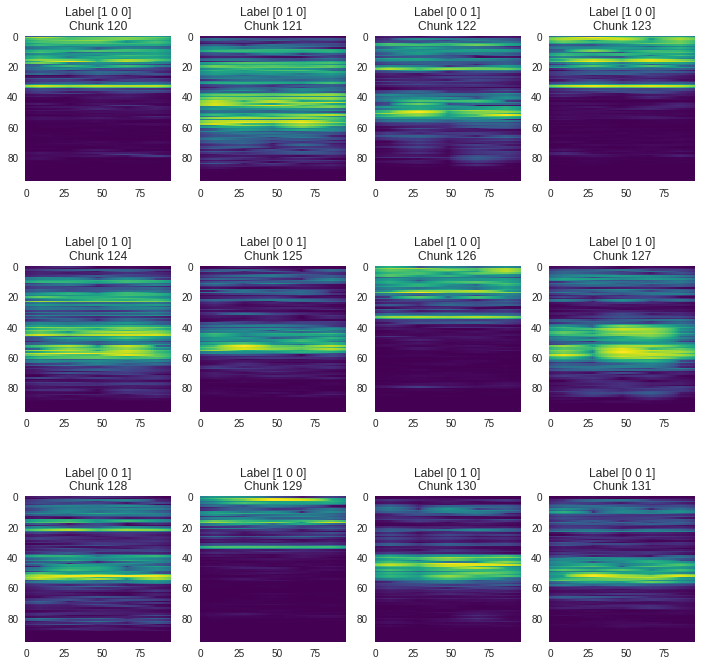

In [5]:
import matplotlib.pyplot as plt

offset = 120  # start at the {offset} chunk, somewhere within the waste of images
plt.rcParams["axes.grid"] = False
fig = plt.figure(figsize=(12, 12))
for i in range(0, 12):
    plt.subplot(3, 4, i+1, title=f'Label {labels_for_cnn_onehot[i+offset]}\nChunk {i+offset}')
    plt.imshow(images_for_cnn[i+offset])
fig.show()

The last step before training is to separate the images into training set and testing set

In [0]:
from sklearn.model_selection import train_test_split

images_train, images_test, labels_train_onehot, labels_test_onehot = \
    train_test_split(
        images_for_cnn, 
        labels_for_cnn_onehot, 
        test_size=0.33, 
        random_state=42)

Now we are ready to run the model

## **Fitting**

Let's first set the fitting parameters.

In [0]:
BATCH_SIZE = 64
NUMBER_OF_EPOCHS = 30
VALIDATION_SPLIT = 0.25

Then load up our model created in step 2, and fit it on the training data set

In [8]:
import keras

model_filename = f'{DEEPPREDICT_HOME}/models/CNN_arch_guo_shape96-96-4-3__initial.h5'
model = keras.models.load_model(model_filename)

history = model.fit(
    images_train, labels_train_onehot,
    batch_size=BATCH_SIZE,
    epochs=NUMBER_OF_EPOCHS, 
    validation_split=VALIDATION_SPLIT, 
    verbose=1)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 2110 samples, validate on 704 samples
Epoch 1/30
2110/2110 [==============================] - 3s 1ms/step - loss: 10.0452 - categorical_accuracy: 0.3322 - val_loss: 10.5088 - val_categorical_accuracy: 0.3480
Epoch 2/30
2110/2110 [==============================] - 1s 702us/step - loss: 7.4182 - categorical_accuracy: 0.3905 - val_loss: 0.4766 - val_categorical_accuracy: 0.8395
Epoch 3/30
2110/2110 [==============================] - 1s 703us/step - loss: 0.5790 - categorical_accuracy: 0.7621 - val_loss: 0.1313 - val_categorical_accuracy: 0.9361
Epoch 4/30
2110/2110 [==============================] - 1s 703us/step - loss: 0.3185 - categorical_accuracy: 0.8460 - val_loss: 0.0348 - val_categorical_accuracy: 0.9972
Epoch 5/30
2110/2110 [================

## Confusion matrix: Predicting the labels of the test set 

Let's see how good our model is by running it on the test set

In [9]:
# Predict the labels of the test set: y_pred
labels_predicted = history.model.predict_classes(images_test, verbose=1)

1386/1386 [==============================] - 1s 400us/step


In [10]:
# for the confusion matrix we need a factorized labels 
# [1,0,0] -> 0 ("N")
# [0,1,0] -> 1 ("IR")
# [0,0,1] -> 2 ("B")
labels_test_factorized = [(1*l[0]+2*l[1]+3*l[2])-1 for l in labels_test_onehot]

from sklearn.metrics import classification_report
print(classification_report(labels_test_factorized, labels_predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       497
           1       1.00      1.00      1.00       448
           2       1.00      1.00      1.00       441

   micro avg       1.00      1.00      1.00      1386
   macro avg       1.00      1.00      1.00      1386
weighted avg       1.00      1.00      1.00      1386



We can see by that confusion matrix, that the model is having a perfect scores on our data. This means the data we are working with is very distinctive, thus causing overfitting.

Therefore trying this technique on a more complex data (different noise levels, data with more gradual changes from normal to fault state, etc) could be the subject of our next implementation. 
